In [1]:
import os
import yaml
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xopt.vocs import VOCS
from xopt.generators.bayesian.models.standard import StandardModelConstructor

from botorch.models.transforms import Normalize

# Read Data from File

In [2]:
f_names = ["exploration_2_nd_filter.yml", "optimization_1.yml", "optimization_2.yml"]
dfs = []
for name in f_names:
    with open(name, "r") as file:
        f = yaml.safe_load(file)
        dfs += [pd.DataFrame(f["data"])]

data = pd.concat(dfs, ignore_index=True)
data = data.dropna(subset=["total_rms_size"])

vocs = VOCS(**f["vocs"])

data

,13ARV1:Cx,13ARV1:Cx_std,13ARV1:Cy,13ARV1:Cy_std,13ARV1:Sx,13ARV1:Sx_std,13ARV1:Sy,13ARV1:Sy_std,13ARV1:image1:ArraySize0_RBV,13ARV1:image1:ArraySize0_RBV_std,...,AWA:Bira3Ctrl:Ch06,AWA:DAC0:Ch08,AWA:Drive:DS1:Ctrl,AWA:Drive:DS3:Ctrl,AWALLRF:K1:SetPhase,AWAVXI11ICT:Ch1,AWAVXI11ICT:Ch1_std,total_rms_size,xopt_error,xopt_runtime
0,366.741006,1.042786,275.659871,1.078548,49.173776,2.934228,28.826575,1.814375,1920.0,0.0,...,0.000000,5.900000,550.000000,190.000000,246.000000,1.000000e-09,1.000000e-10,57.000278,False,6.519966
2,397.269688,0.930661,326.124423,0.367013,37.662779,1.367888,36.723681,1.425068,1920.0,0.0,...,-0.205224,5.648132,515.167227,201.626571,244.592257,1.000000e-09,0.000000e+00,52.603362,False,9.304709
3,359.242144,0.212839,257.678494,0.867668,8.290947,0.108205,25.447795,0.211115,1920.0,0.0,...,0.666339,5.740590,534.700417,238.097827,245.257044,1.000000e-09,0.000000e+00,26.764343,False,6.672761
4,359.765084,2.554813,359.018039,1.354696,43.836924,1.588441,42.266556,1.805961,1920.0,0.0,...,-0.563728,5.651622,524.219058,240.648635,251.057976,1.000000e-09,1.000000e-10,60.894480,False,6.924069
8,324.197813,0.523856,335.574353,0.949796,34.920597,1.728933,47.167652,1.047655,1920.0,0.0,...,0.764509,5.786961,540.821016,197.484758,240.502847,9.000000e-10,0.000000e+00,58.687609,False,6.583808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,379.740925,0.334171,254.839659,2.984119,24.750789,2.125275,58.038760,4.274663,1920.0,0.0,...,0.844822,5.858779,549.817748,193.260737,244.235764,1.000000e-09,0.000000e+00,63.095952,False,5.926540
331,360.410297,0.679712,288.578086,0.295716,73.190952,3.536619,10.575606,0.141557,1920.0,0.0,...,0.884273,5.881126,549.378874,197.164072,245.995864,1.000000e-09,1.000000e-10,73.951057,False,6.853666
332,364.810155,1.914085,305.388279,0.248109,97.349745,1.987374,11.168152,0.195587,1920.0,0.0,...,0.290603,5.891154,549.749476,193.711944,244.451600,9.000000e-10,0.000000e+00,97.988267,False,16.119790
333,373.183715,0.428123,274.109694,0.140853,9.384570,0.113718,37.039526,0.561171,1920.0,0.0,...,0.884564,5.824810,548.414362,195.813235,244.653898,1.000000e-09,0.000000e+00,38.209902,False,6.133165


                              0           1
AWA:Bira3Ctrl:Ch03    -1.306105   -0.306105
AWA:Bira3Ctrl:Ch04    -1.276121   -0.276121
AWA:Bira3Ctrl:Ch05     1.205201    2.205201
AWA:Bira3Ctrl:Ch06    -0.368432    0.631568
AWA:DAC0:Ch08          4.859338    4.999338
AWA:Drive:DS1:Ctrl   499.670090  504.670090
AWA:Drive:DS3:Ctrl   204.105682  212.105682
AWALLRF:K1:SetPhase  249.911686  251.911686
AWA:Bira3Ctrl:Ch03      -5.0
AWA:Bira3Ctrl:Ch04      -5.0
AWA:Bira3Ctrl:Ch05      -5.0
AWA:Bira3Ctrl:Ch06      -5.0
AWA:DAC0:Ch08            4.5
AWA:Drive:DS1:Ctrl     500.0
AWA:Drive:DS3:Ctrl     180.0
AWALLRF:K1:SetPhase    236.0
Name: 0, dtype: float64
AWA:Bira3Ctrl:Ch03       5.0
AWA:Bira3Ctrl:Ch04       5.0
AWA:Bira3Ctrl:Ch05       5.0
AWA:Bira3Ctrl:Ch06       5.0
AWA:DAC0:Ch08            5.9
AWA:Drive:DS1:Ctrl     550.0
AWA:Drive:DS3:Ctrl     260.0
AWALLRF:K1:SetPhase    256.0
Name: 1, dtype: float64
{'AWA:Bira3Ctrl:Ch03': [-1.3061046426, -0.30610464260000003], 'AWA:Bira3Ctrl:Ch04': [-1.2761

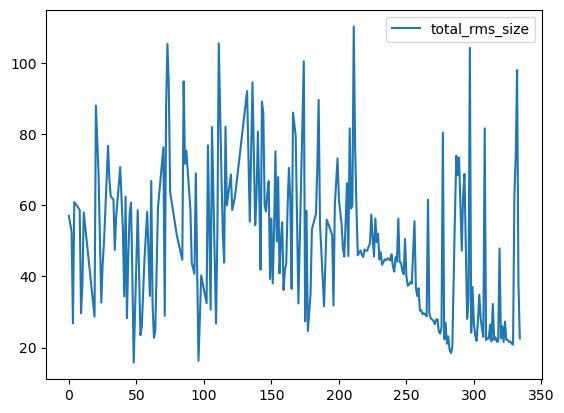

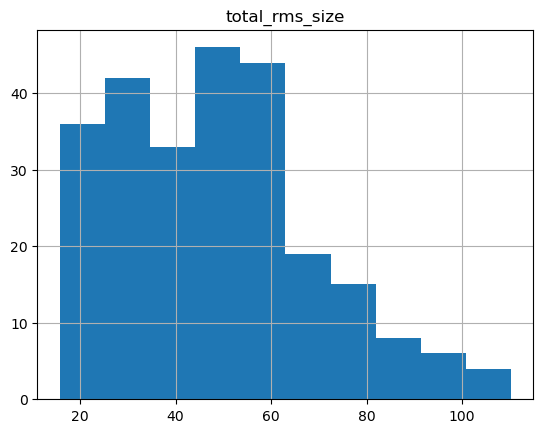

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

data.plot(y="total_rms_size")
data.hist("total_rms_size")

min_x = data[vocs.variable_names].iloc[data["total_rms_size"].to_numpy().argmin()]
variable_bounds = pd.DataFrame(vocs.variables)
variable_widths = variable_bounds.iloc[1] - variable_bounds.iloc[0]

scale = 0.1
custom_bounds = pd.concat([
    min_x - variable_widths*scale / 2,
    min_x + variable_widths*scale / 2,
],
    axis=1
)
print(custom_bounds)

custom_bounds = custom_bounds.clip(
    variable_bounds.iloc[0],
    variable_bounds.iloc[1],
    axis=0
)

# clip
print(variable_bounds.iloc[0])
print(variable_bounds.iloc[1])

custom_bounds = custom_bounds.T.to_dict()
for k in custom_bounds.keys():
    custom_bounds[k] = [custom_bounds[k][i] for i in range(2)]
print(custom_bounds)


In [4]:
# prepare output directory
output_dir = "./models/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Build GP Model and Generate Training Data

In [5]:
model_constructor = StandardModelConstructor()
gp = model_constructor.build_model_from_vocs(vocs, data)
gp

ModelListGP(
  (models): ModuleList(
    (0-1): 2 x SingleTaskGP(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): MaternKernel(
          (lengthscale_prior): GammaPrior()
          (raw_lengthscale_constraint): Positive()
        )
        (outputscale_prior): GammaPrior()
        (raw_outputscale_constraint): Positive()
      )
      (outcome_transform): Standardize()
      (input_transform): Normalize()
    )
  )
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
)

In [6]:
model_constructor

StandardModelConstructor(name='standard', use_low_noise_prior=True, covar_modules={}, mean_modules={}, trainable_mean_keys=[], dtype=torch.float64, device='cpu')

## generate bootstrap points

In [7]:


from xopt.generators.bayesian.objectives import feasibility
th = 0.98
bs_data = []
for i in range(10):
    print(i)
    test_x = torch.from_numpy(
        pd.DataFrame(vocs.random_inputs(1000, custom_bounds=custom_bounds)).to_numpy()
    )

    test_x = test_x.cuda()
    gp = gp.cuda()

    # calculate posterior
    with torch.no_grad():
        post = gp.posterior(test_x)
        mean = post.mean

        # calculate feasibility probability
        feas = feasibility(test_x.unsqueeze(1), gp, vocs).flatten()

    bs_data += [[test_x[feas > th], mean[feas > th]]]


0


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
torch_bs_data_x = torch.vstack([ele[0] for ele in bs_data])
torch_bs_data_y = torch.vstack([ele[1] for ele in bs_data])[:,0]

torch.save(torch_bs_data_x, "bs_local_data_x.pt")
torch.save(torch_bs_data_y, "bs_local_data_y.pt")

In [ ]:
plt.hist(torch_bs_data_y.numpy(), bins=100);

In [ ]:
# get training data from measured data
x_meas = torch.from_numpy(data[vocs.variable_names].to_numpy())
y_meas = torch.from_numpy(data[vocs.objective_names[0]].to_numpy()).unsqueeze(-1)
x_meas.shape, y_meas.shape

In [ ]:
# augment training data with GP posterior samples
n_aug = 1 * y_meas.shape[0]
x_aug = vocs.random_inputs(n_aug)
x_aug = torch.from_numpy(pd.DataFrame(x_aug)[vocs.variable_names].to_numpy())
y_aug = gp.posterior(x_aug).mean.detach()
x_aug.shape, y_aug.shape

In [ ]:
# # generate grid data
# n_pts = 3  # points per grid dimension
# x_i = [torch.linspace(*x_lim[i], n_pts) for i in range(len(x_lim))]
# x = torch.cartesian_prod(*x_i)
# print(x.shape)

In [ ]:
x = torch.cat([x_meas, x_aug])
y = torch.cat([y_meas, y_aug])
# x, y = x_meas, y_meas
x.shape, y.shape

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.hist(y.squeeze().numpy(), bins=10)
fig.tight_layout()

In [ ]:
# define train/test data
train_frac = 0.8
idx = torch.randperm(x.shape[0])
x, y = x[idx].double(), y[idx].double()
idx_split = int(train_frac * x.shape[0])
x_train, y_train = x[:idx_split], y[:idx_split]
x_test, y_test = x[idx_split:], y[idx_split:]

# save training and test data
torch.save({"x": x_train, "y": y_train}, output_dir + "train_data.pt")
torch.save({"x": x_test, "y": y_test}, output_dir + "test_data.pt")

# Prepare Training

In [ ]:
# define in- and output transformers
x_transformer = Normalize(x_dim, bounds=x_lim.T)
y_transformer = Normalize(y_dim, bounds=y_lim.T)
torch.save(x_transformer.state_dict(), output_dir + "x_transformer.pt")
torch.save(y_transformer.state_dict(), output_dir + "y_transformer.pt")

In [ ]:
# define data set
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x, self.y, = x, y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x, y

In [ ]:
def create_model():
    model = nn.Sequential(
        nn.Linear(8, 16),
        nn.Tanh(),
        nn.Dropout(p=0.05),
        nn.Linear(16, 16),
        nn.Tanh(),
        nn.Dropout(p=0.05),
        nn.Linear(16, 8),
        nn.Tanh(),
        nn.Linear(8, 1)
    )
    return model.double()

In [ ]:
class TransformedModel(nn.Module):
    def __init__(self, model, x_transformer, y_transformer):
        super(TransformedModel, self).__init__()
        self.model = model
        self.x_transformer = x_transformer
        self.y_transformer = y_transformer
    
    def forward(self, x):
        x = self.x_transformer(x)
        x = self.model(x)
        x = self.y_transformer.untransform(x)
        return x

In [ ]:
# define dataloaders
pin_memory = True
batch_size = y.shape[0]
trainset = Dataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                                          num_workers=0, pin_memory=pin_memory)
testset = Dataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, 
                                         num_workers=0, pin_memory=pin_memory)

# Train Surrogate Models

In [ ]:
lr = 1e-3
n_epochs = int(1e5)
model = TransformedModel(create_model(), x_transformer, y_transformer)
optimizer = optim.Adam(model.parameters(), lr=lr)  # , weight_decay=3e-6

In [ ]:
# define loss function
class CustomLoss(nn.MSELoss):
    def __init__(self, penalty: float = 1.0, size_average=None, reduce=None,
                 reduction: str = 'mean') -> None:
        """Customized MSELoss which penalized negative predictions.

        Args:
            size_average: Inherited from torch.nn.MSELoss().
            reduce: Inherited from torch.nn.MSELoss().
            reduction: Inherited from torch.nn.MSELoss().
        """
        super(CustomLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        mask = x < 0.0
        delta = x - y
        delta_sum = torch.sum(delta[~mask] ** 2)
        delta_sum += torch.sum(delta[mask] ** 4)
        return delta_sum / y.shape[0]

    
#         return F.mse_loss(x, y, reduction=self.reduction)

    
#         mask = tar > threshold
#         if torch.all(tar <= threshold):
#             return F.mse_loss(0 * inp, 0 * tar, reduction=self.reduction)
#         if self.standardized_loss:
#             inp_eval = standardize(inp, dim=(-2, -1), keepdim=True)[mask]
#             tar_eval = standardize(tar, dim=(-2, -1), keepdim=True)[mask]
#         else:
#             inp_eval, tar_eval = inp[mask], tar[mask]
#         return F.mse_loss(inp_eval, tar_eval, reduction=self.reduction)

criterion = nn.L1Loss()
# criterion = nn.MSELoss()
# criterion = CustomLoss()

In [ ]:
# train model
train_losses = []
test_losses = []
print("{:8s} {:>12s} {:>12s} {:>12s}".format("EPOCH", "TRAIN_LOSS", "TEST_LOSS", "ETA"))
t0 = time.time()
best_loss = 1.0
for epoch in range(n_epochs):
    for i, batch_data in enumerate(trainloader, 0):
#         # save model to file
#         if i == 0:
#             torch.save(model, output_dir + "{:d}ep.pt".format(epoch))

        inputs, labels = batch_data
        optimizer.zero_grad()
        model.train()
        outputs = model(inputs)
#         if epoch == 0 or epoch == n_epochs - 1:
#             print(model.y_transformer(outputs).shape, model.y_transformer(labels).shape)
#             print(model.y_transformer(outputs)[:10], model.y_transformer(labels)[:10])
        loss = criterion(model.y_transformer(outputs), model.y_transformer(labels))
        loss.backward()
        optimizer.step()

        if i == 0:
            model.eval()
            inputs_test, targets_test = next(iter(testloader))
            outputs_test = model(inputs_test)
            test_loss = criterion(model.y_transformer(outputs_test), model.y_transformer(targets_test))

            # store losses
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            
            if epoch % (n_epochs // 10) == 0:
                # save model to file
                if i == 0:
                    torch.save(model, output_dir + "{:d}ep.pt".format(epoch))
                
                # print info
                t_avg = (time.time() - t0) / (epoch + 1)
                t_r = (n_epochs - epoch - 1) * t_avg / 60  # in minutes
                if t_r <= 1.0:
                    t_info = "{:.2f} sec".format(60 * t_r)
                else:
                    t_info = "{:.2f} min".format(t_r)
                info = "{:<8d} {:12.5f} {:12.5f} {:>12s}".format(epoch, loss, test_loss, t_info)
                if test_loss < best_loss:
                    info = "\033[0;32m" + info + '\x1b[0m'
                print(info)
                if test_loss < best_loss:
                    best_loss = test_loss

t_total = time.time() - t0
t_r = t_total / 60  # in minutes
if t_r <= 1.0:
    t_info = "{:.2f} sec".format(60 * t_r)
else:
    t_info = "{:.2f} min".format(t_r)                
print("Total runtime: {}".format(t_info))

# # save final model to file
# torch.save(model, output_dir + "{:d}ep.pt".format(n_epochs))

In [ ]:
# plot training process
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_xlabel("Epoch")
ax.plot(train_losses, c="C0", label="training loss")
ax.plot(test_losses, c="C1", label="test loss")
ax.set_ylabel(criterion.__class__.__name__)
ax.legend(loc="upper right")
ax.set_axisbelow(True)
ax.set_yscale("log")
ax.grid(color="gray", linestyle="dashed")

In [ ]:
idx = np.argmin(data[vocs.objective_names[0]].values)
ref_pt = data[vocs.variable_names].iloc[idx].values

In [ ]:
n = 1000
model.eval()
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(12, 20))
for i, name in enumerate(vocs.variable_names):
    # get data
    axis = torch.linspace(*vocs.variables[name], n)
    d = torch.from_numpy(ref_pt).unsqueeze(0).repeat([n, 1])
    d[:, i] = axis    
    pred = model(d)
    targets = gp.posterior(d).mean
    # plot
    ax_i = ax[i % 4, i // 4]
    ax_i.set_title(name)
    ax_i.plot(axis, pred.detach(), label="predictions")
    ax_i.plot(axis, targets.detach(), label="targets")
    ax_i.legend()

In [ ]:
pred_test = model(x_test)
plt.plot(y_test, pred_test.detach(), "x")

In [ ]:
pred_train = model(x_train)
plt.plot(y_train, pred_train.detach(), "x")

In [ ]:
pred_meas = model(x_meas)
plt.plot(y_meas, pred_meas.detach(), "x")